In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import japanize_matplotlib
from pathlib import Path
import tqdm

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


In [4]:
# データ準備
beer_sales_df = pd.read_csv("data/3-2-1-beer-sales-2.csv")

print(beer_sales_df.shape)
print(beer_sales_df.head)

(100, 2)
<bound method NDFrame.head of      sales  temperature
0    41.68         13.7
1   110.99         24.0
2    65.32         21.5
3    72.64         13.4
4    76.54         28.9
..     ...          ...
95   44.94         13.9
96   76.11         18.5
97   58.00         11.9
98   38.65         12.3
99   52.04         18.8

[100 rows x 2 columns]>


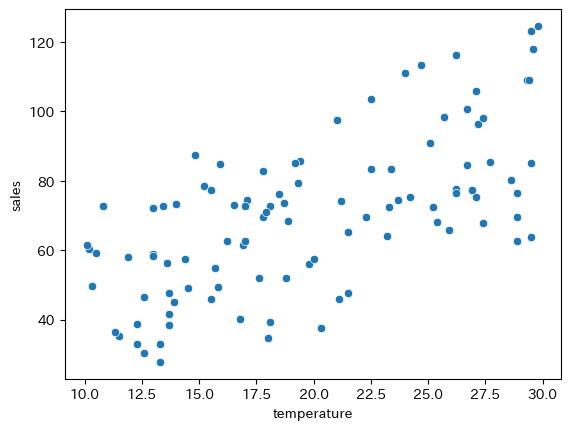

In [5]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=beer_sales_df, x="temperature", y="sales")

In [6]:
# データの準備
X = beer_sales_df["temperature"]
y = beer_sales_df["sales"]

In [7]:
X.shape

(100,)

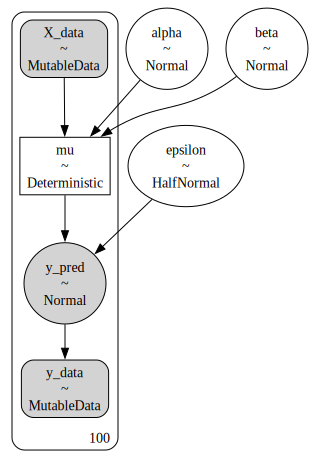

In [8]:
# 確率モデルの定義
model = pm.Model()

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X, mutable=True)

    # パラメータを確率変数として定義
    alpha = pm.Normal("alpha", mu=0, sigma=10000)
    beta = pm.Normal("beta", mu=0, sigma=10000)

    # 目的変数の期待値を確率変数として定義
    mu = pm.Deterministic("mu", alpha * X_data + beta)

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=10000)

    # 観測値を持つ確率変数として定義
    obs = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_data)    

g = pm.model_to_graphviz(model)
display(g)

In [9]:
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


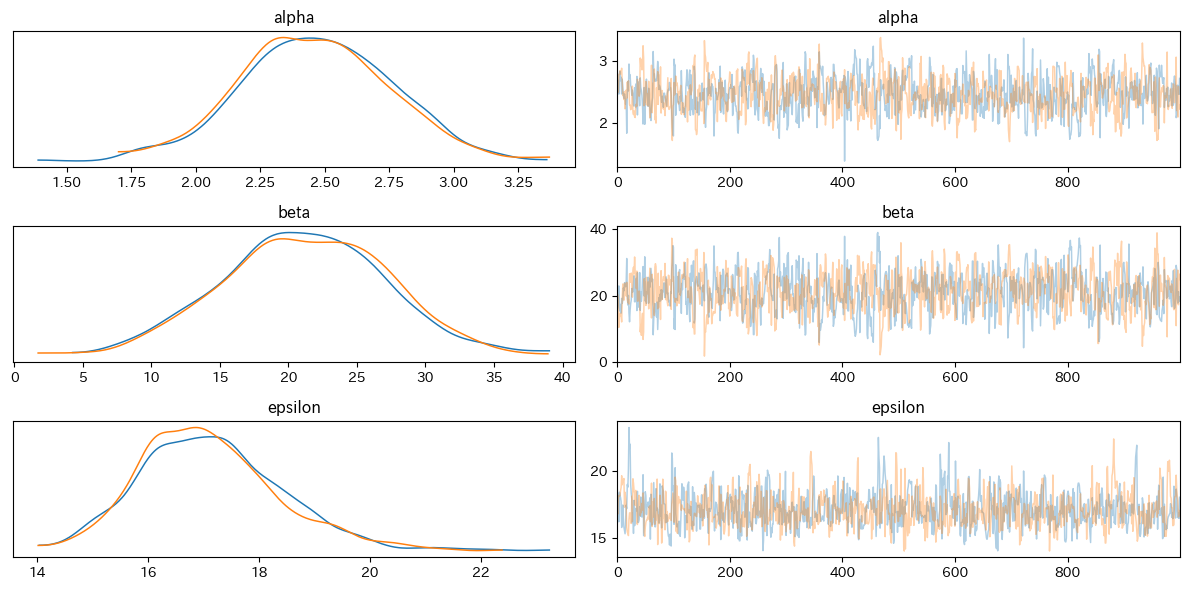

In [10]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

In [11]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["alpha", "beta", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.463,0.286,1.882,2.962,0.011,0.008,653.0,879.0,1.0
beta,21.144,5.951,9.465,31.749,0.234,0.165,650.0,806.0,1.0
epsilon,17.113,1.284,14.805,19.533,0.045,0.032,871.0,725.0,1.0


In [62]:
# パラメータの抽出
alpha_ifr = idata1["posterior"]["alpha"].values.reshape(-1, 1)
beta_ifr = idata1["posterior"]["beta"].values.reshape(-1, 1)
tmptr = np.array(11)

,0
count,2000.000000
mean,48.239493
std,3.090595
min,38.250064
5%,43.053373
50%,48.181240
95%,53.341151
max,57.991858


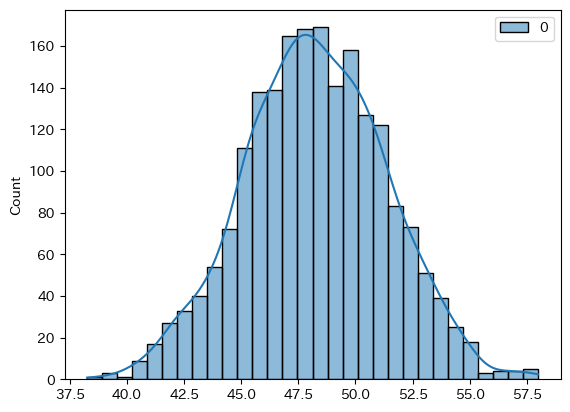

In [73]:
# 気温が11度のときの、売上の期待値の分布
mu_11dc = alpha_ifr * tmptr + beta_ifr
display(pd.DataFrame(mu_11dc).describe(percentiles=[0.05, 0.95]))

fig, ax = plt.subplots()
ax = sns.histplot(data=mu_11dc, kde=True)

plt.show();

In [12]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [13]:
X_new = np.array([11])

In [78]:
with model:
    pm.set_data({"X_data":X_new})
    idata1.extend(pm.sample_posterior_predictive(idata1))

Sampling: [y_pred]


In [83]:
idata1

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [80]:
samples = idata1["predictions"]["y_pred"][0, :, :].values.reshape(-1)
samples.shape

(100000,)